# Deep Learning for Computer Vision

---

**Goethe University Frankfurt am Main**

Winter Semester 2022/23

<br>

## *Assignment 1 (Filtering)*

---

**Points:** 60<br>
**Due:** 2.11.2022, 10 am<br>
**Contact:** Matthias Fulde ([fulde@cs.uni-frankfurt.de](mailto:fulde@cs.uni-frankfurt.de))<br>

---

**Your Name:** Tilo-Lars Flasche

<br>

<br>

## Table of Contents

---

- [1 Convolution and Cross Correlation](#1-Convolution-and-Cross-Correlation-(30-Points))
  - [1.1 Algebraic Properties](#1.1-Algebraic-Properties-(10-Points))
  - [1.2 Dimension Formula](#1.2-Dimension-Formula-(5-Points))
  - [1.3 Implementation](#1.3-Implementation-(15-Points))
- [2 Separable Filters](#2-Separable-Filters-(10-Points))
  - [2.1 Correctness](#2.1-Correctness-(5-Points))
  - [2.2 Complexity](#2.2-Complexity-(5-Points))
- [3 Edge Detection](#3-Edge-Detection-(10-Points))
 - [3.1 Gradient Magnitude](#3.1-Gradient-Magnitude-(5-Points))
 - [3.2 Gradient Direction](#3.2-Gradient-Direction-(5-Points))
- [4 Image Denoising](#4-Image-Denoising-(10-Points))
  - [4.1 Gaussian Approximation](#4.1-Gaussian-Approximation-(5-Points))
  - [4.2 Comparsion](#4.2-Comparsion-(5-Points))


<br>

## Setup

---

In this notebook we use the libraries **Matplotlib**, **NumPy** and **OpenCV**. We recommend to use at least the 3.x versions of OpenCV. You can check your version with the statements below.

In [1]:
import numpy as np
import cv2 as cv

# Check installed OpenCV version.
cv.__version__

'4.6.0'

We want Matplotlib figures to appear within the notebook rather than inside a separate window, which is default in some environments, therefore we make use of the `%matplotlib` magic function to set the Matplotlib backend to inline.

In [2]:
import matplotlib.pyplot as plt

# Set default color map and interpolation method for images.
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

%matplotlib inline

We import a utility function to show images. See `utils.py` for documentation.

In [3]:
from utils import display

<br>

### Definitions

---

We define an `error` function to measure the relative difference between two outcomes.

In [4]:
def error(x, y):
    """
    Calculate the sum of the relative differences.
    The absolute differences are scaled with the sum of the absolute values.

    Parameters:
        - x, y: Arrays with equal shape.

    Returns:
        - Error between x and y.

    """
    x = x.astype(np.float32)
    y = y.astype(np.float32)

    return np.sum(abs(x - y) / (abs(x) + abs(y)))

<br>

## Exercises

---

### 1 Convolution and Cross Correlation (30 Points)

---

In the lecture, *convolution* and *cross correlation* were introduced as operations that allow to apply a filter to an image.

In order to get familiar with them, we're going to show some mathematical properties of the operations and find a formula that describes how these operations transform the dimensions of the input image with respect to their hyperparameters. Finally, we'll implement the operation on our own.

However, before we start, let's briefly recap the definitions.

---

For simplicity, we define the input $I$ and filter $K$ as discrete functions with finite support, rather than as matrices.

Then the **cross correlation** operation can be defined as

$$
    (I \star K)[m, n]
    =
    \sum_{k = -\infty}^\infty
    \sum_{l = -\infty}^\infty
    I[k, l] \,
    K[m + k, n + l].
$$

The **convolution** operation in the discrete case for real values is exactly the same, except that the filter is flipped along both axes, that is, the order of the entries is reversed. We can define it as

$$
    (I * K)[m, n]
    =
    \sum_{k = -\infty}^\infty
    \sum_{l = -\infty}^\infty
    I[k, l] \,
    K[m - k, n - l].
$$

Note that the definition of $I$ and $K$ as functions with finite support implies that the infinite sums are absolutely convergent.

Regarding the convolution of images with multiple channels, we assume that the number of channels of the input and the filter matches. Then each input channel is convolved with the respective channel of the filter and the per channel outputs are added up to give the final output.

<br>

### 1.1 Algebraic Properties (10 Points)

---

The convolution operation is commutative, associative, and distributive over addition. Furthermore, it is associative with scalar multiplication. The identity element of the operation is the Dirac delta. In this section we want to show, that these claims are actually true.

<br>

#### 1.1.1 Commutativity (2 Points)

Given the definition above, show that the convolution operation with input $I$ and filter $K$ is commutative, that is

$$
    I * K = K * I.
$$


##### Proof

*Write your proof here.*

First we define two new variables:
$A = m - k$, $B = n - l$

From these definitions we can derive:
$k = m - A$, $l = n - B$

$$
\begin{array}{lcll}
    (I * K)[m, n]
    &=&
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    I[k, l] \,
    K[m - k, n - l]
    & \text{ | swap order of multiplication}
    \\
    &=&
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    K[m - k, n - l] \,
    I[k, l]
    & \text{ | substitute k, l, m - k and n - l}
    \\
    &=&
    \underbrace{
    \sum\limits_{A = -\infty}^\infty
    \sum\limits_{B = -\infty}^\infty
    K[A, B] \,
    I[m - A, n - B]
    }_{\text{This is just the definition of the convolution} (K * I)[A,B]}
    & \text{ | Rename A to k and B to l}
    \\
    &=&
    \sum\limits_{A = -\infty}^\infty
    \sum\limits_{B = -\infty}^\infty
    K[k, l] \,
    I[m - k, n - l]
    &
\end{array}
$$

<br>

#### 1.1.2 Associativity (2 Points)

Again let $I$ be the input and let $K_1$ and $K_2$ be two filters. Show that the convolution operation with input $I$ and filters $K_1$ and $K_2$ is associative, that is

$$
    I * (K_1 * K_2) = (I * K_1) * K_2.
$$


##### Proof

*Write your proof here.*

$$
\begin{array}{lcl}
    (I * (K_1 * K_2))[m, n]
    &=&
    \left(I *
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    K_1[k, l] \,
    K_2[m - k, n - l]
    \right)
    [m,n]
    \\
    &=&
    \left(
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    I * (
    K_1[k, l] \,
    K_2[m - k, n - l]
    )
    \right)
    [m,n]
    \\
    &=&
    \left(
    \sum\limits_{a = -\infty}^\infty
    \sum\limits_{b = -\infty}^\infty
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    I[a,b] \,
    K_1[k, l] \,
    K_2[m - a - k, n - b - l]
    \right)
    [m,n]
    \\
    &=&
    \left(
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    K_1[k, l] \,
    \sum\limits_{a = -\infty}^\infty
    \sum\limits_{b = -\infty}^\infty
    I[a,b] \,
    K_2[m - a - k, n - b - l]
    \right)
    [m,n]
    \\
    &=&
    \left(
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    K_1[k, l] \,
    (I * K_2)[m-k,n-l]
    \right)
    [m,n]
    \\
    &=&
    ((I * K_2) * K_1)[m,n]
    \\
\end{array}
$$

#### 1.1.3 Distributivity (2 Points)

Given an input $I$ and filters $K_1$ and $K_2$, show that convolving the input with a sum of filters is the same as adding the results of convolving the input with the individual filters, i.e. show that convolution is distributive over addition, that is

$$
    I * (K_1 + K_2) = (I * K_1) + (I * K_2).
$$


##### Proof

*Write your proof here.*

$$
\begin{array}{lcl}
    (I * (K_1 + K_2))[m, n]
    &=&
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    I[k, l] \,
    ((K_1 + K_2)[m - k, n - l])
    \\
    &=&
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    I[k, l] \,
    (K_1[m - k, n - l] + K_2[m - k, n - l])
    \\
    &&
    \text{Now we can apply the commutativity rule for multiplication: a(b+c) = ab+ac}
    &
    \\
    &=&
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    \left(
    I[k, l] \,
    K_1[m - k, n - l]
    + 
    I[k, l] \, 
    K_2[m - k, n - l]
    \right)
    \\
    &&
    \text{Split the sum into to two parts: } \sum a+b = \sum a + \sum b
    &
    \\
    &=&
    \underbrace{
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    I[k, l] \,
    K_1[m - k, n - l]
    }_{\text{This is the definition of }(I * K_1)[m,n]}
    +
    \underbrace{
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    I[k, l] \, 
    K_2[m - k, n - l]
    }_{\text{This is the definition of }(I * K_2)[m,n]}
    \\
    &=&
    (I * K_1)[m,n] + (I * K_2)[m,n]
\end{array}
$$

<br>

#### 1.1.4 Scalar Multiplication (1 Point)

Let $\alpha \in \mathbb{R}$. Show that the convolution operation with input $I$ and filter $K$ is associative with respect to scalar multiplication, that is

$$
    (\alpha I) * K = \alpha(I * K).
$$


##### Proof

*Write your proof here.*

$$
\begin{array}{lcll}
    ((\alpha I) * K)[m, n]
    &=&
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    \alpha I[k, l] \,
    K_2[m - k, n - l]
    & \text{| alpha is a constant and can be pulled out of the sum} &
    \\
    &=&
    \alpha
    \underbrace{
    \sum\limits_{k = -\infty}^\infty
    \sum\limits_{l = -\infty}^\infty
    I[k, l] \,
    K_2[m - k, n - l]}_{I * K[m,n]}
    &
    \\
    &=& \alpha(I * K)[m, n]
    &
\end{array}
$$

<br>

#### 1.1.5 Identity (1 Point)

The identity element of the convolution operation that preserves the input is the Dirac delta, which in the discrete case can be defined as

$$
    \delta[m,n]
    =
    \begin{cases}
        1 & \text{if} \enspace m = n = 0 \\
        0 & \text{otherwise}.
    \end{cases}
$$

Show that $\delta$ does not change the input $I$, that is

$$
    I * \delta = I.
$$


##### Proof

*Write your proof here.*

$$
    (I * \delta)[m, n]
    =
    \sum_{k = -\infty}^\infty
    \sum_{l = -\infty}^\infty
    \underbrace{
    I[k, l] \,
    \delta[m - k, n - l]
    }_{\text{This term is zero if not m-k=0 and n-l=0}}
$$

We only have to look at one specific case: $m-k=0 \Rightarrow m = k$ and $n-l=0 \Rightarrow n = l$, because the term inside of the sums would be zero otherwise.

$$
\begin{array}{lcll}
    (I * \delta)[m, n]
    &=&
    \sum_{k = -\infty}^\infty
    \sum_{l = -\infty}^\infty
    \underbrace{
    I[k, l] \,
    \delta[m - k, n - l]
    }_{\text{This term is zero if not m-k=0 and n-l=0}}
    &
    \\
    &=&
    I[k, l] \,
    \delta[0, 0]
    & \text{ | } \delta[0,0] = 1
    \\
    &=&
    I[k, l]
    & \text{ | substitute k with m and l with n}
    \\
    &=&
    I[m, n]
    &
    \\
\end{array}
$$

<br>

#### 1.1.6 Linearity (2 Points)

Does the discrete convolution operation constitute a linear map, satisfying the additivity and homogeneity conditions?<br>Prove your answer.

Additivity: $f(x+y) = f(x) + f(y)$

Homogenity: $f(ax) = a f(x) \quad\vert\quad a = const$

##### Answer

*Write your answer here.*

##### Proof

*Write your proof here.*

<br>

### 1.2 Dimension Formula (5 Points)

---

In practice we can't compute an infinite sum, so we have to handle the *boundaries* of the given inputs.

To preserve the dimensions of the input, we apply **padding** to the image, that means we add pixels to the start and end of each dimension. The size of the padding as well as the values used for the additional pixels are hyperparameters to the convolution and cross correlation operations.

The same holds for the **stride**, which determines how far we move the filter in each step.

<br>

![convolution](images/convolution.png)

<br>

Take the above figure as an example for strided convolution with padding. ([Dumoulin and Visin](#ref-1))

Here, a $3 \times 3$ filter is applied to a $5 \times 5$ input image, with 1 pixel padding and a stride of 2, resulting in an output image of size $3 \times 3$. The first valid filter position is over the top left pixel of the input, due to the applied padding. The filter is then slided across the columns and rows of the input, skipping one pixel in each step, due to the two pixel stride.

---

Consider an input image $I_\text{in} \in \mathbb{R}^{N \times N}$ and a filter $K \in \mathbb{R}^{M \times M}$ with $M, N \in \mathbb{N}$ and $M$ being odd. In practice, neither the input nor the filter have to be square, but the transformation is the same in each dimension, so for this exercise, we can assume they are.

We convolve $I_\text{in}$ with $K$ to get the output $I_\text{out}$, that is

$$
    I_\text{out} = I_\text{in} * K.
$$

For this operation, we assume uniform padding with $P$ pixels. That means the same amount of padding is applied to each of the borders of the image. In addition, we use a stride of $S$ pixels in both directions.

<br>

#### 1.2.1 Task

Derive a formula to compute the size $D$ of the output image $I_\text{out}$ given the size $N$ of the input image $I_\text{in}$, the size $M$ of the filter $K$, the number of pixels used for padding $P$, and the stride $S$. For each part of the formula, give a brief explanation.

<br>

#### 1.2.2 Solution

*Write your solution here.*

The whole image with padding has a size of $N + 2P$, because we fill the image on both sides with zeros

If stride equals one and there is no padding we can shift the kernel $N - M + 1$ times in each direction

If we double the stride we only need half the number of shifts of the kernel to cover the whole image. If we set the stride to the value S we only need 1/S shifts of the kernel to cover the whole image.

Now if we put all these together we get the following formula for the size of the output image.

$$ D = \frac{N + 2P - M + 1}{S} $$

<br>

### 1.3 Implementation (15 Points)

---

In this exercise, our goal is to implement the convolution and cross correlation operations by ourselves.

<br>

#### 1.3.1 Task

Complete the definition of the `filter2D` function below.

The function should perform *convolution* or *cross correlation* on the input image and the given filter. The function should work for inputs with one or more channels and produce a single channel output with the same data type as the input image.

Depending on the given arguments, the function should [pad](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) the spatial dimensions of the input with zeros before the filter is applied, and it should also work for strides larger than one. It should [flip](https://numpy.org/doc/stable/reference/generated/numpy.flip.html) the kernel horizontally and vertically to perform convolution if requested.

Only functions and overloaded operators from NumPy or plain Python are allowed.

In order to encourage you to write performant vectorized code, full points are only awarded if no more than two loops are used.

<br>

#### 1.3.2 Solution

Enter your solution in the code cell below. Store the output in the given variable.

In [150]:
def filter2D(image, kernel, padding=0, stride=1, flip=False):
    """
    Convolve or correlate a grayscale or color image with a filter kernel.

    Notes:
        - The number of channels in image and kernel must match.
        - The format must be spatial dimensions before channels.
        - The output has the same data type as the input.

    Parameters:
        - image: Grayscale or color image.
        - kernel: Filter kernel.
        - padding: Uniform zero padding for the input image.
        - stride: Uniform stepsize for the kernel.
        - flip: Flip the kernel for convolution.

    Returns:
        - out: The filtered image.

    """
    ############################################################
    ##                   START OF YOUR CODE                   ##
    ############################################################
    
    # Calculate the dimension of the output image
    D = int((image.shape[0] + 2*padding - kernel.shape[0] + 1) / stride)
    
    # Apply padding
    image = np.pad(image, padding, 'constant', constant_values=0)
    
    # remove padding of axis 2 if image is 3D
    if (len(image.shape) == 3):
        image = image[:, :, 1:4]

    # Flip kernel if convolution should be calculated
    if flip:
        kernel = np.flip(kernel)

    # Calculate the correlation between the image and the (flipped) kernel
    out = np.zeros((D,D))
    
    for x in range(D):
        for y in range(D):
            index_start_x = x * stride
            index_end_x = x * stride + kernel.shape[0]
            index_start_y = y * stride
            index_end_y = y * stride + kernel.shape[0]
            out[x][y] = (image[index_start_x:index_end_x, index_start_y:index_end_y] * kernel).sum()
    
    ############################################################
    ##                    END OF YOUR CODE                    ##
    ############################################################
    return out

<br>

#### 1.3.3 Test

For testing your implementation, two test cases are given below.

In [151]:
def create_test_inputs(x_range, x_shape, k_range, k_shape):
    """
    Generates a test image and a filter.
    The pixel values are sampled evenly distributed over the specified ranges.

    Parameters:
        - x_range: Range for image values.
        - x_shape: Shape of the image.
        - k_range: Range for filter values.
        - k_shape: Shape of the filter.

    Returns:
        - x: Test image.
        - k: Test filter.

    """
    x = np.linspace(*x_range, num=np.prod(x_shape)).reshape(x_shape)
    k = np.linspace(*k_range, num=np.prod(k_shape)).reshape(k_shape)

    return x, k

In [152]:
# Test function with a grayscale image and unit stride.
image, kernel = create_test_inputs(
    (-.1, .5), (5, 5),
    (-.2, .3), (3, 3)
)

# Apply the kernel to the image
result = filter2D(image, kernel, padding=1, stride=1)

difference = error(result, np.array([
    [.0075,     .030625,  .0521875,  .07375,   .0475   ],
    [.114375,   .1725,    .18375,    .195,     .10875  ],
    [.1753125,  .22875,   .24,       .25125,   .1228125],
    [.23625,    .285,     .29625,    .3075,    .136875 ],
    [.0075,    -.05375,  -.0603125, -.066875, -.1025   ]
]))

print(f'Difference is {difference}')

Difference is 0.0


In [153]:
# Test function with a color image and non unit stride.
image, kernel = create_test_inputs(
    (-.3, .5), (4, 4, 3),
    (-.2, .4), (3, 3, 3)
)

result = filter2D(image, kernel, padding=1, stride=2)

difference = error(result, np.array([
    [-0.30343699, -0.05081833],
    [ 0.89572831,  1.44898527]
]))

print(f'Difference is {difference}')

Difference is 0.0


<br>

### 2 Separable Filters (10 Points)

---

A **separable filter** is a filter that can be written as the product of two or more simpler filters.

In particular, a two-dimensional separable filter can be decomposed in the product of two one-dimensional filters. The subsequent convolution with the lower dimensional filters can reduce the computational cost significantly.

For instance, consider a filter $K \in \mathbb{R}^{h \times w}$. The matrix shaped filter $K$ is separable if we can write it as the outer product of two vector shaped filters $\mathbf{k}^{(1)} \in \mathbb{R}^h$ and $\mathbf{k}^{(2)} \in \mathbb{R}^w$, as in

$$
    K
    \:=\:
    \alpha\beta
    \begin{bmatrix}
        k_1^{(1)} k_1^{(2)} & \cdots & k_1^{(1)} k_w^{(2)} \\
        \vdots  & \ddots & \vdots  \\
        k_h^{(1)} k_1^{(2)} & \cdots & k_h^{(1)} k_w^{(2)}
    \end{bmatrix}
    \:=\:
    \alpha
    \begin{bmatrix}
        k_1^{(1)} \\
        \vdots \\
        k_h^{(1)}
    \end{bmatrix}
    \:
    \beta
    \begin{bmatrix}
        k_1^{(2)} & \cdots & k_w^{(2)}
    \end{bmatrix}
    \:=\:
    \mathbf{k}^{(1)}
    \,
    \mathbf{k}^{(2)\top},
$$

where $\alpha, \beta \in \mathbb{R}$.

<br>

### 2.1 Correctness (5 Points)

---

Let $I \in \mathbb{R}^{H \times W}$. Show that the convolution of the input $I$ with the filter $K$ is the same as the sequential convolution of $I$ with the simpler filters $\mathbf{k}^{(1)}$ and $\mathbf{k}^{(2)}$, that is

$$
    I * K = (I * \mathbf{k}^{(1)}) * \mathbf{k}^{(2)}.
$$


##### Proof

*Write your proof here.*

<div style="text-align:right">$\square$</div>

<br>

### 2.2 Complexity (5 Points)

---

Given the example above of a separable two dimensional filter $K$, derive asymptotic upper bounds for the computational complexity of the convolution $I * K$ and the sequential application of the filters $\mathbf{k}^{(1)}$ and $\mathbf{k}^{(2)}$ to the input $I$. Explain your results.

<br>

##### Answer

*Write your answer here.*

<br>

### 3 Edge Detection (10 Points)

---

In the lecture we have seen, that we can **detect edges** by approximating the image gradient in horizontal and vertical direction. We remember that for a one-dimensional differentiable function $f(x)$, the gradient corresponds to the derivative, which can be expressed as the limit of the difference quotient

<br>

$$
    \frac{\text{d}}{\text{d}x} f(x)
    =
    \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}
    \mathrel{\hat{=}}
    \lim_{h \to 0} \frac{f(x + h) - f(x - h)}{2h}\, .
$$

<br>

However, in the discrete image domain, we can only take differences at one pixel intervals, so we cannot actually compute the gradient at a given image location. But we can adapt the above formula. That is, for a one-dimensional discrete function $f[x]$, we can compute

<br>

$$
    \frac{\text{d}}{\text{d}x} f[x]
    \approx
    \frac{f[x + 1] - f[x - 1]}{2}\, .
$$

<br>

Consequently, interpreting an image $I$ as a two variable discrete function mapping indices to pixel intensities, we can approximate the gradient as

<br>

$$
    \nabla I
    =
    \left[
        \frac{\partial I}{\partial x},
        \frac{\partial I}{\partial y}
    \right]
    \approx
    \left[
        \frac{I[x+1, y] - I[x-1, y]}{2},
        \frac{I[x, y+1] - I[x, y-1]}{2}
    \right].
$$

<br>

The image gradient encodes the information in which direction the pixel intensity increases the most, and by which rate.


<br>

### 3.1 Gradient Magnitude (5 Points)

---

The amount by which the image intensity is changing when moving into the direction of the fastest increase is given by the **magnitude** of the gradient, which is the $L_2$ norm of the vector, i.e.

$$
    \lVert \nabla I \rVert
    =
    \sqrt{\left(\frac{\partial I}{\partial x}\right)^2 + \left(\frac{\partial I}{\partial y}\right)^2\:}.
$$

<br>

#### 3.1.1 Task

We want to use the magnitude of the image gradient to construct a simple edge detector.

In order to do this, define two $3 \times 3$ *correlation* kernels `Kx` and `Ky`, to approximate the image gradient in $x$ and $y$ direction, based on the central difference formula given above. When doing this, you can ignore the normalization by the factor $\frac{1}{2}$. The resulting filter kernels should look familiar, as they correspond to an operator introduced in the lecture. Which one?

Proceed as follows:

1. Convert the color image loaded below to grayscale, and cast the data type to `float32`.
2. Use the [filter2D](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04) function from OpenCV to apply the filters you defined to the image, such that the outputs have the same data type as the input.
3. Compute the magnitude of the gradient manually, using only arithmetic functions and operators from NumPy.

For this exercise, no loops are allowed.

<br>

#### 3.1.2 Solution

Write your solution in the marked code cell below. Store filter kernels and result in the given variables.

In [235]:
# Read color image without alpha channel.
color = cv.imread('images/lenna.jpg')

# Swap red and blue channel.
color = cv.cvtColor(color, cv.COLOR_BGR2RGB)

In [238]:
############################################################
##                   START OF YOUR CODE                   ##
############################################################

gray = cv.cvtColor(color, cv.COLOR_BGR2GRAY).astype(np.float32)

kernel_x = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
kernel_y = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

Kx = cv.filter2D(gray, ddepth=-1, kernel=kernel_x)
Ky = cv.filter2D(gray, ddepth=-1, kernel=kernel_y)

mag = np.sqrt(np.square(Kx) + np.square(Ky))

############################################################
##                    END OF YOUR CODE                    ##
############################################################

<br>

#### 3.1.3 Result

Display your result with the following statement.

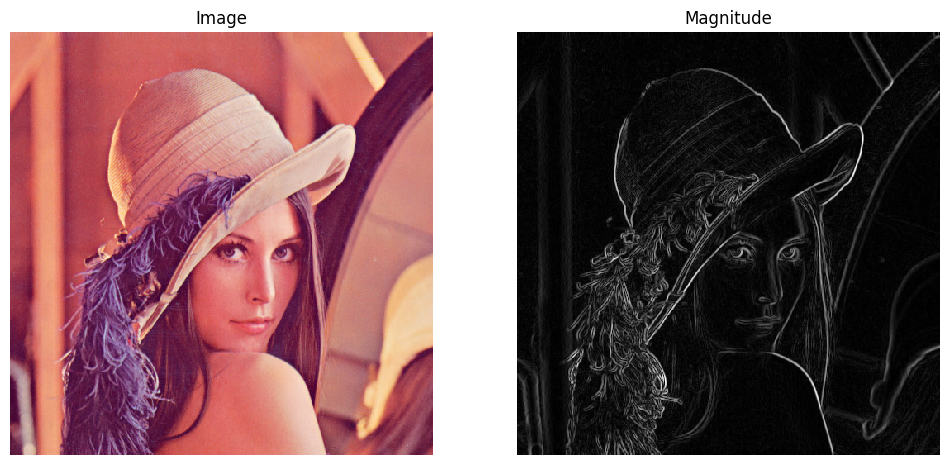

In [239]:
# Show original image and extracted edges.
display((12, 6), [
    (color, 'Image',     121),
    (mag,   'Magnitude', 122)
])

<br>

### 3.2 Gradient Direction (5 Points)

---

The direction of the gradient, which is the direction where the image intensity changes the most, can be computed as

$$
    \theta
    =
    \tan^{-1}
    \left(
        \frac{\nabla_y I}{\nabla_x I}
    \right).
$$

<br>

#### 3.2.1 Task

In this exercise, we want to use the direction of the gradient to extract only a subset of edges with a particular orientation from the image, namely those edges roughly parallel to the counterdiagonal ╱ of the image.

To approximate the image gradient, we'll use the separable **Sobel** operator. Decompose the $3 \times 3$ correlation kernels of the Sobel operator into two vector shaped kernels $\mathbf{k}_1$ and $\mathbf{k}_2$ that can be sequentially applied to the input image.

Proceed as follows:

1. Convert the color image loaded below to grayscale, and cast the data type to `float32`.
2. Use the [sepFilter2D](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#ga910e29ff7d7b105057d1625a4bf6318d) function from OpenCV to apply the filters you defined to the image, such that the outputs have the same data type as the input.
3. This time you can use the function [cartToPolar](https://docs.opencv.org/4.6.0/d2/de8/group__core__array.html#gac5f92f48ec32cacf5275969c33ee837d) to compute both magnitude and angle of the image gradient.
4. The [inRange](https://docs.opencv.org/4.6.0/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981) function can be used to create a mask for a suitable angular range.
5. Apply the mask with the [bitwise_and](https://docs.opencv.org/4.6.0/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14) function to the magnitude.

The result doesn't have to be perfect. It's enough if you extract the diagonal edges reasonably well.

<br>

#### 3.2.2 Solution

Write your solution in the marked code cell below. Store the kernels, the gradient magnitude and the final result in the given variables.

In [215]:
# Read color image without alpha channel.
color = cv.imread('images/grid.jpg')

# Swap red and blue channel.
color = cv.cvtColor(color, cv.COLOR_BGR2RGB)

In [388]:
############################################################
##                   START OF YOUR CODE                   ##
############################################################

# Convert the image to grayscale
gray = cv.cvtColor(color, cv.COLOR_BGR2GRAY).astype(np.float32)

# Define kernels
k1 = np.array([1,2,1])
k2 = np.array([-1,0,1])

# Apply filters to image
filtered_image_x = cv.sepFilter2D(gray, ddepth=-1, kernelX=k1, kernelY=k2)
filtered_image_y = cv.sepFilter2D(gray, ddepth=-1, kernelX=k2, kernelY=k1)

# Calculate magnitude matrix and angle matrix
mag, angle = cv.cartToPolar(filtered_image_x, filtered_image_y)

# Find angles that are close to 45° or 225°
tolerance = 0.25
diag_mask = cv.inRange(angle, 3.14/4 - tolerance, 3.14/4 + tolerance) | cv.inRange(angle, 5*3.14/4 - tolerance, 5*3.14/4 + tolerance)
diag = mag * (diag / 255)

############################################################
##                    END OF YOUR CODE                    ##
############################################################

<br>

#### 3.2.3 Result

Display your result with the following statement.

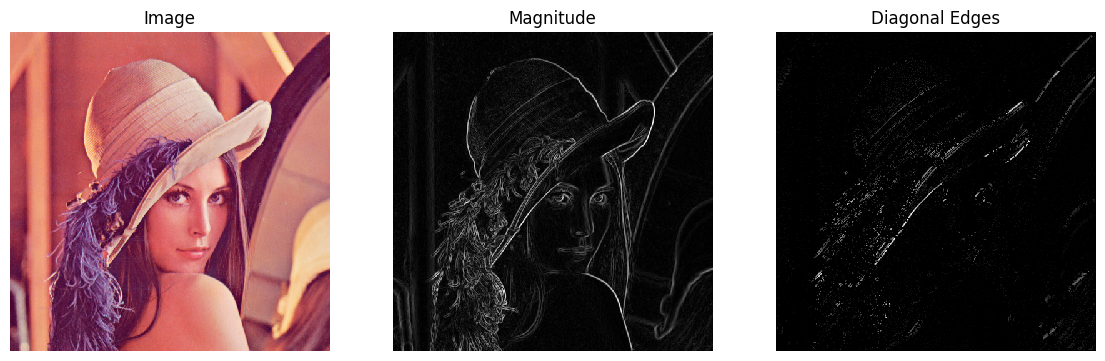

In [389]:
# Show original image and extracted edges.
display((14, 5), [
    (color, 'Image',          131),
    (mag,   'Magnitude',      132),
    (diag,  'Diagonal Edges', 133)
])

<br>

### 4 Image Denoising (10 Points)

---

In the lecture, different filters for **image denoising** have be introduced. In particular, the box filter, the Gaussian filter, and the median filter.

These filters have in common that they are *low pass* filters, meaning that they remove high frequency components from an image, which are characterized by large differences between the intensities of adjacent pixels. Since noise itself has a high frequency, it is reduced by the application of these filters.

<br>

### 4.1 Approximation (5 Points)

---

In this exercise we'll see that we can approximate a Gaussian filter by the repeated application of box filters. To this end, we'll create a synthetic image and blur the image using both filter types, comparing the results.

<br>

#### 4.1.1 Task

As a reference, filter the image created below with a Gaussian filter, using the [GaussianBlur](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1) function of OpenCV.

For the Gaussian blur, use a standard deviation of $\sigma = 20$ and call the function with the `ksize` parameter set to `None`, so that the kernel size is computed automatically from the given $\sigma$ value.

Let $K$ be the number of iterations to apply the box filter to the image. For a good approximation of the Gaussian filter, the following relation between the filter radius $r$ of the box filter, the number of iterations $K$, and the standard deviation $\sigma$ has been suggested ([Wells](#ref-2)):

<br>

$$
    r = \Bigg\lfloor\frac{1}{2}\sqrt{\frac{12}{K}\sigma^2 + 1}\,\Bigg\rfloor
$$

<br>

Compute the size of the kernel for the box filter accordingly and use the [blur](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37) function from OpenCV to smooth the image, for $K=1$ and $K=5$.

The result of applying the box filter 5 times should look pretty similar to the result for the Gaussian filter.

<br>

#### 4.1.2 Solution

Write your solution in the marked code cell below. Store the outputs in the given variables.

In [390]:
# Set image size.
size = 127

# Create empty image to draw on.
canvas = np.zeros((size,size), np.uint8)

# Draw white circle.
image = cv.circle(canvas, center=(size//2,size//2), radius=size//3, color=255, thickness=cv.FILLED)

In [410]:
############################################################
##                   START OF YOUR CODE                   ##
############################################################

# Calculate r
get_r = lambda k: int(0.5 * np.sqrt(12/k * 20**2 + 1))

# Filter images with box filters
box_1 = cv.blur(image, ksize=(get_r(1),get_r(1)))
box_5 = cv.blur(image, ksize=(get_r(5),get_r(5)))

# Filter image with gaussian filter
gaussian = cv.GaussianBlur(image, sigmaX=20, sigmaY=20, ksize=None)

############################################################
##                    END OF YOUR CODE                    ##
############################################################

<br>

#### 4.1.3 Result

Display your result with the following statement.

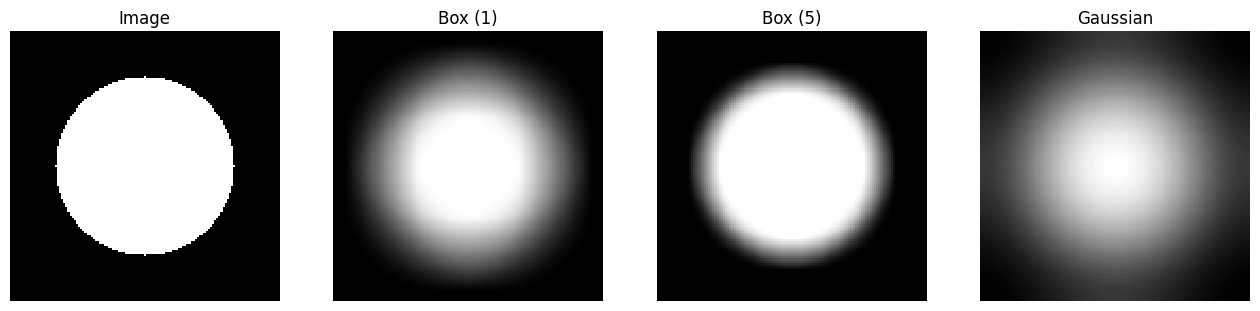

In [411]:
# Show blurred images alongside original.
display((16, 4), [
    (image,    'Image',    141),
    (box_1,    'Box (1)',  142),
    (box_5,    'Box (5)',  143),
    (gaussian, 'Gaussian', 144)
])

<br>

### 4.2 Comparsion (5 Points)

---

In this exercise we want to compare the introduced filters with respect to the **image denoising** task. In particular, we want to investigate the effects of applying the box, Gaussian, and median filters to an image corrupted with so called salt and pepper noise.

Salt and pepper noise is characterized by typically sparse distributions of erroneous pixels that are either totally white or totally black. It can be caused by bit errors during data transmission or errors during analog-digital conversion.

<br>

#### 4.2.1 Task (2 Points)

In order to make the results comparable, we'll use the *same* filter size of $5 \times 5$ for all three filters taken into consideration.

Proceed as follows:

1. Apply a box filter with the given size to the image loaded below, using the `blur` function introduced above.
2. Construct a two-dimensional Gaussian filter from two $5 \times 1$ kernels obtained from the [getGaussianKernel](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa) function.
3. Apply the two-dimensional Gaussian filter to the image using the `filter2D` function.
4. Apply a median filter of the same size using the [medianBlur](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9) function.

No loops are allowed in this exercise.

<br>

#### 4.2.2 Solution

Write your solution in the marked code cell below. Store the outputs in the given variables.

In [412]:
# Load grayscale image.
image = cv.imread('images/einstein.png', cv.IMREAD_GRAYSCALE)

In [439]:
############################################################
##                   START OF YOUR CODE                   ##
############################################################

# Apply a 5x5 box filter to the image
box = cv.blur(image, ksize=(5,5))

# First construct a 1D gaussian kernel
gaussian_kernel_1D = cv.getGaussianKernel(sigma=20, ksize=5)

# Multiply 1D kernel with transposed 1D kernel to get a 2D gaussian kernel
gaussian_kernel_2D = gaussian_kernel_1D @ gaussian_kernel_1D.T

# Apply the 2D gaussian kernel to the image
gaussian = filter2D(image, gaussian_kernel_2D, padding=1, stride=1, flip=False)

# Apply a median filter to the image
median = cv.medianBlur(image, ksize=5)

############################################################
##                    END OF YOUR CODE                    ##
############################################################

<br>

#### 4.2.3 Result

Display your result with the following statement.

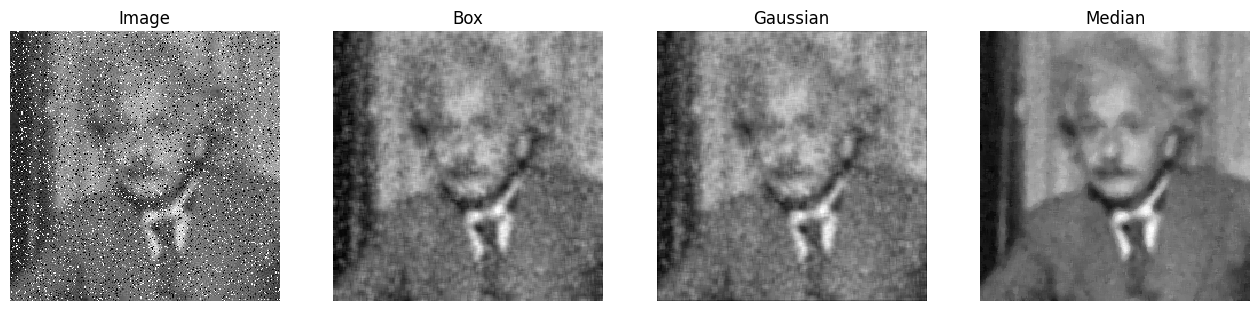

In [440]:
# Show filtered images alongside original.
display((16, 4), [
    (image,    'Image',    141),
    (box,      'Box',      142),
    (gaussian, 'Gaussian', 143),
    (median,   'Median',   144)
])

#### 4.2.4 Analysis (3 Points)

Describe your observations. Which filter worked best removing the noise from the image? Explain why this is expected given the properties of this kind of noise and the definitions of the respective filters. Be precise in your formulations and write at least four to five sentences.

##### Answer

*Write your answer here.*

The median filter works best for removing noise from the image. The box filter and the gaussian filter may improve the image quaality, but you are still able to see some noise in the image.

This is because the gaussian and the box filter calculate a weighted average of the surrounding pixels. So the noise is also included in this average value. The median filter in the other side can completely ignorenoisy pixels, because the noisy pixels usually contain extreme bright or extreme dark values, which the median filter ignores by only picking the median value of the surrounding pixels.

<br>

### References

---

1. <span id="ref-1">V. Dumoulin and F. Visin, "A guide to convolution arithmetic for deep learning", 2016.</span>
2. <span id="ref-2">W.M. Wells, “Efficient synthesis of Gaussian filters by cascaded uniform filters”, <i>IEEE Transactions on Pattern Analysis and Machine Intelligence</i>, vol. 8, no. 2, pp. 234–239, 1986.</span>

<br>